In [1]:
spark

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 6, Finished, Available)

In [93]:
## Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, IndexToString
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 98, Finished, Available)

In [3]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_clean_v2.parquet"
submissions_path = "/basketball_submissions_clean.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 8, Finished, Available)

In [4]:
comments = comments.cache()
submissions = submissions.cache()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 9, Finished, Available)

In [120]:
comments = comments.filter(col("subreddit")=="CollegeBasketball")
comments = comments.withColumn("hour", hour("created_utc"))
comments = comments.withColumn("popular", when(comments["score"] > 8, 1).otherwise(0))
comments = comments.withColumn("comment_length", length("body"))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 125, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 126, Finished, Available)

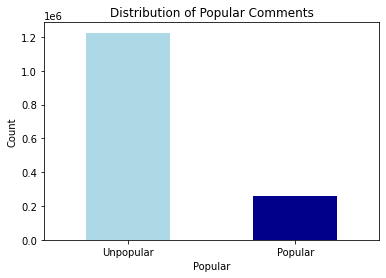

In [121]:
pandas_df = comments.select("popular").toPandas()

counts = pandas_df['popular'].value_counts()
counts.plot(kind='bar', color=['lightblue', 'darkblue'])

# Add labels and title
plt.title("Distribution of Popular Comments")
plt.xlabel('Popular')
plt.ylabel('Count')
plt.xticks(rotation = 0, ticks = [0,1],labels = ["Unpopular", "Popular"])
# Show the plot
plt.show()

In [49]:
window_spec = Window.partitionBy("author")
comments = comments.withColumn("author_activity", F.count("author").over(window_spec))

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 54, Finished, Available)

In [122]:
train_data, test_data = comments.randomSplit([0.8, 0.2], seed = 82)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
train_data = train_data.cache()

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 127, Finished, Available)

Number of training records: 1186384
Number of testing records : 296383


In [123]:
stringIndexer_team = StringIndexer(inputCol='supported_team', outputCol="supported_team_index", handleInvalid="skip") 
label_indexer = StringIndexer(inputCol="popular", outputCol="popular_label", handleInvalid="skip")
onehot_team = OneHotEncoder(inputCol="supported_team_index", outputCol="supported_team_vec")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 128, Finished, Available)

In [124]:
feature_cols = ['comment_length', 'day', 'month', 'year', 'hour', 'author_activity',"supported_team_vec"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 129, Finished, Available)

In [125]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedPopularity", 
                               labels= label_indexer.fit(train_data).labels)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 130, Finished, Available)

In [126]:
model = RandomForestClassifier(featuresCol="features", labelCol="popular_label", numTrees = 100)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 131, Finished, Available)

In [109]:
model = LogisticRegression(featuresCol="features", labelCol="popular_label")

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 114, Finished, Available)

In [127]:
pipeline_model = Pipeline(stages = [
    stringIndexer_team,
    label_indexer,
    onehot_team,
    assembler,
    model,
    labelConverter
])

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 132, Finished, Available)

In [128]:
model = pipeline_model.fit(train_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 133, Finished, Available)

In [129]:
predictions = model.transform(test_data)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 134, Finished, Available)

In [130]:
evaluator = BinaryClassificationEvaluator(labelCol="popular_label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result = evaluator.evaluate(predictions)
roc_result

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 135, Finished, Available)

0.5

In [131]:
predictions.select("popular", "prediction", "probability").show(truncate=False)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 43, 136, Finished, Available)

+-------+----------+----------------------------------------+
|popular|prediction|probability                             |
+-------+----------+----------------------------------------+
|0      |0.0       |[0.8178938375166349,0.182106162483365]  |
|0      |0.0       |[0.8155509173573235,0.1844490826426765] |
|0      |0.0       |[0.8164810526834876,0.18351894731651242]|
|1      |0.0       |[0.8178938375166349,0.182106162483365]  |
|0      |0.0       |[0.8225913808572595,0.17740861914274056]|
|0      |0.0       |[0.8148095140765591,0.18519048592344084]|
|1      |0.0       |[0.8164810526834876,0.18351894731651242]|
|0      |0.0       |[0.8257076806691251,0.17429231933087494]|
|0      |0.0       |[0.8193853001173805,0.18061469988261952]|
|0      |0.0       |[0.8145539199713497,0.1854460800286502] |
|0      |0.0       |[0.8217323767300901,0.1782676232699098] |
|0      |0.0       |[0.8217323767300901,0.1782676232699098] |
|0      |0.0       |[0.8164810526834876,0.18351894731651242]|
|0      